In [2]:
cd /home/emilio/density_test/ho2d/ho2d_res


/home/emilio/density_test/ho2d/ho2d_res


/tmpa/emilio/miniconda3/envs/new/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
"""
This program relies on Metropolis-Hastings algorithm (a type of Markov chain Monte Carlo method)
for sampling the probability density of a high dimensional wavefunction. 

The output will be the geometries in terms of cartesian coordinates at which we have a representative
sample of the probability density. This will allow us to, thanks to electronic structure packages, calculate
time-resolved observables (transient absoption, time-resolved spectroscopies, ...)

"""

import subprocess
import sys
import os
import numpy as np
import concurrent.futures
import multiprocessing as mp

############################## INPUT SECTION ####################################


# Define the path to the Fortran executable

number_nmodes = 2               # Number of degrees of freedom
number_states = 1
idx_time = 1                    # Time index to perfrom the sampling (Starts at 0)
path_to_mctdh = "/home/emilio/mctdh86_new/"


sp_executable = 'sp_psi86'      # Single point wf program
den1d_executable = "showd1d86"  # 1D density program

sp_full_path = path_to_mctdh + "bin/binary/x86_64/" + sp_executable
den1d_full_path = path_to_mctdh + "bin/binary/x86_64/" + den1d_executable


# Define the flags to pass

sp_flags = ['-w', '-ort', '-skip', f"{idx_time}", '-n', '1']


analyse_dir = path_to_mctdh + 'source/analyse'
if analyse_dir not in sys.path:
    sys.path.append(analyse_dir)
import montecarlo_tools as mct

############################## RUN 1D-DENSTIES ##################################
full_1dden_data = [] # The dimensions are (number_modes, time_steps, 3(grid, 1d_den, 1d_den_2nd_pop))
for mode in range(number_nmodes):
    # Flags for running showd1d86 (rewrite and go through the different modes)
    den1d_flags = ['-w',f"f{mode+1}" ]
    cmd = [den1d_full_path] + den1d_flags
    try:
        # Execute the Fortran program
        result = subprocess.run(
            cmd,
            capture_output=True,
            text=True,
            check=True
        )
        file_path = f'./den1d_f{mode+1}'  # Replace with your actual file path
        # READ ALL 1D DENSITIES
        all_times_den1d, line_counts = mct.extract_plot_data(file_path)
        full_1dden_data.append(all_times_den1d)
        print(f"In mode {mode+1} there are {np.shape(all_times_den1d)[0]} steps in time.")
        print(f"In mode {mode+1} there are {np.shape(all_times_den1d)[1]} grid points.\n")

    except subprocess.CalledProcessError as e:
        # Handle errors in execution
        print(f"An error occurred while running the Fortran executable for mode {mode+1}")
        print(f"Return Code: {e.returncode}")
        print(f"Standard Output:\n{e.stdout}")
        print(f"Standard Error:\n{e.stderr}")
        sys.exit(1)


############################## RUN INITIAL SAMPLING #############################

num_samples = 50  # Number of samples
n_clusters = 20  # Adjust the number of clusters

# Perform sampling for n DoFs
sampled_grid_points, sampled_indices = mct.sample_n_dofs(full_1dden_data, num_samples,idx_time)

# Remove duplicate grid points and indices
unique_sampled_grid_points = mct.remove_duplicates(sampled_grid_points)
unique_sampled_indices = mct.remove_duplicates(sampled_indices)

# Perform clustering and select representative grid points and indices
representative_grid_points, representative_indices = mct.cluster_sampling(unique_sampled_indices, unique_sampled_grid_points, n_clusters)

# Save both grid points and indices
# save_samples_and_indices(representative_grid_points, representative_indices, filename_prefix='mcmc')


# Initialize sp_psi with the same length as representative_indices
sp_psi = [None] * len(representative_indices)

with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    futures_to_idx = {
        executor.submit(
            mct.run_and_collect,
            sp_full_path,
            sp_flags,
            grid.astype(int).tolist()
        ): idx
        for idx, grid in enumerate(representative_indices)
    }
    
    for future in concurrent.futures.as_completed(futures_to_idx):
        idx = futures_to_idx[future]
        psi = future.result()
        if psi is not None:
            sp_psi[idx] = psi  # Make sure to store the psi_values in the correct order
            print(f"Sample {idx + 1}: Collected psi_values.")
        else:
            print(f"Sample {idx + 1}: Failed to collect psi_values.")


In mode 1 there are 3 steps in time.
In mode 1 there are 15 grid points.

In mode 2 there are 3 steps in time.
In mode 2 there are 20 grid points.

Sample 4: Collected psi_values.
Sample 2: Collected psi_values.
Sample 1: Collected psi_values.
Sample 3: Collected psi_values.
Sample 6: Collected psi_values.
Sample 5: Collected psi_values.
Sample 8: Collected psi_values.
Sample 7: Collected psi_values.
Sample 10: Collected psi_values.
Sample 9: Collected psi_values.
Sample 11: Collected psi_values.
Sample 13: Collected psi_values.
Sample 14: Collected psi_values.
Sample 12: Collected psi_values.
Sample 15: Collected psi_values.
Sample 16: Collected psi_values.
Sample 18: Collected psi_values.
Sample 19: Collected psi_values.
Sample 17: Collected psi_values.
Sample 20: Collected psi_values.


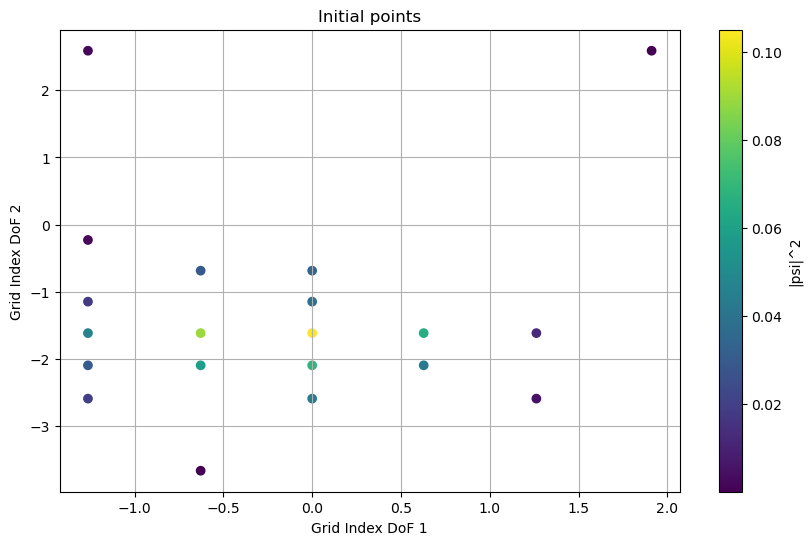

In [8]:
import matplotlib.pyplot as plt

# Example for the first two DoFs
plt.figure(figsize=(10, 6))
plt.scatter(representative_grid_points[:, 0], representative_grid_points[:, 1], c=np.array(sp_psi).flatten(), cmap='viridis')
plt.colorbar(label='|psi|^2')
plt.xlabel('Grid Index DoF 1')
plt.ylabel('Grid Index DoF 2')
plt.title('Initial points')
plt.grid(True)
plt.show()
    

In [9]:
sp_psi

[0.08915228995647768,
 0.0001602626914272001,
 0.0659073249862138,
 0.0021321518771663353,
 0.04362106747434278,
 0.0018489226889781747,
 0.03485621398307416,
 0.00036578001495518695,
 0.00506913794890098,
 0.046420518805797645,
 0.019280033884767966,
 0.04313947923073684,
 0.06874477570640689,
 0.01745532633231782,
 0.012204958502279751,
 0.0295879059583875,
 0.039492667506682226,
 0.058354414501796036,
 0.03038443765274378,
 0.10502640167149616]

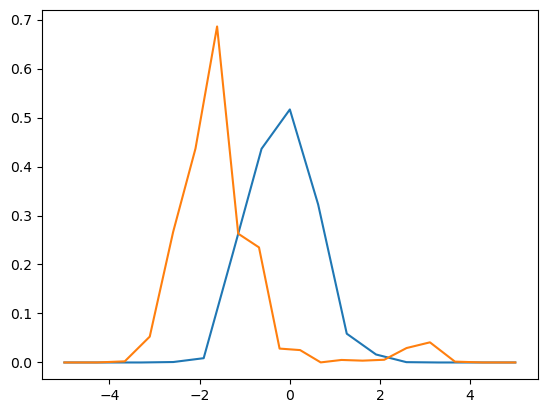

In [10]:
import matplotlib.pyplot as plt
plt.figure()
for i in range(number_nmodes):
    plt.plot(full_1dden_data[i][1][:,0] ,full_1dden_data[i][1][:,1])

In [11]:
initial_indices = np.array([representative_indices for states in range(number_states)])
initial_indices = representative_indices
grid_shape = tuple(np.shape(full_1dden_data[i])[1] for i in range(number_nmodes))
executable_path = sp_full_path
flags = sp_flags
initial_sp_psi = sp_psi

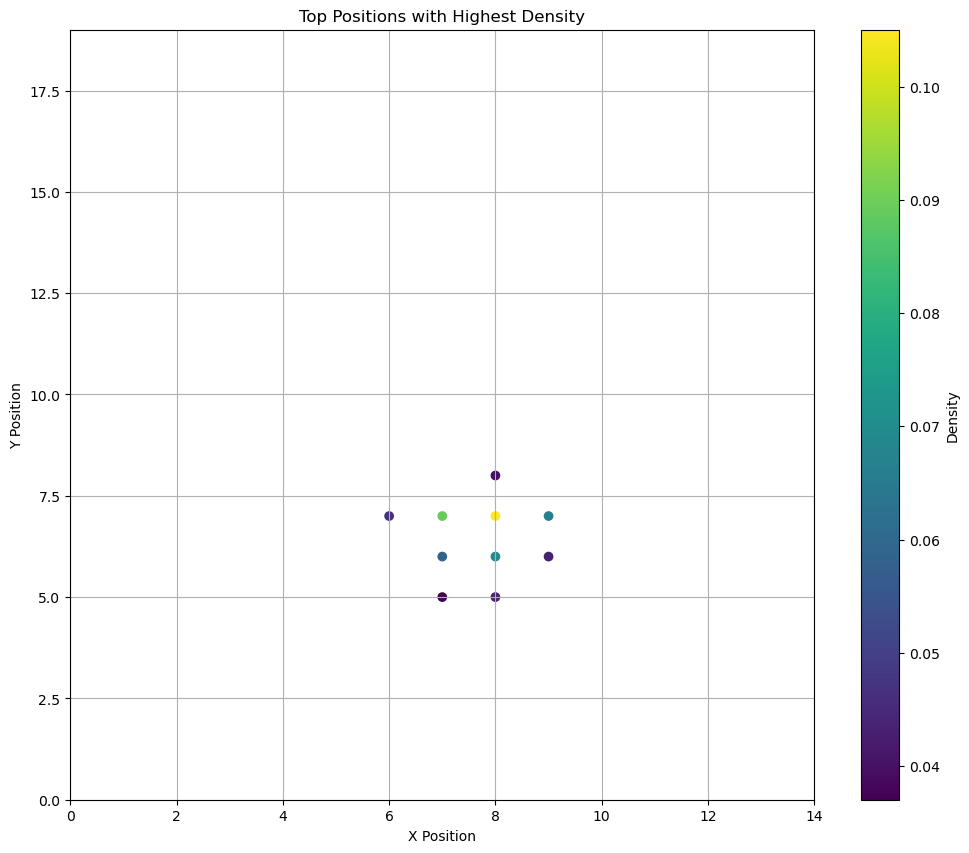

In [12]:
# Define parameters
num_steps = 2500  # Number of steps in the Metropolis algorithm
boundary = 'periodic'  # Choose 'reflect' or 'periodic'

# Run Metropolis in parallel
samples = mct.metropolis_parallel(
    initial_indices,
    initial_sp_psi,
    grid_shape,
    mct.run_and_collect,
    executable_path,
    flags,
    num_steps,
    boundary
)

# Define the maximum number of unique positions you want to collect
max_unique_positions = 10  # Adjust this number as desired

# Use a dictionary to store positions and their maximum densities
positions_density_dict = {}

for walker_samples in samples:
    # Include all steps, no burn-in discard
    for position, density in walker_samples:
        pos_key = tuple(position)
        # Keep the maximum density for each position
        if pos_key in positions_density_dict:
            positions_density_dict[pos_key] = max(positions_density_dict[pos_key], density)
        else:
            positions_density_dict[pos_key] = density

# Create a list of (position, density) tuples
positions_density_list = list(positions_density_dict.items())

# Sort the positions by density in descending order
positions_density_list.sort(key=lambda x: x[1], reverse=True)

# Select the top positions with maximum density
top_positions_density = positions_density_list[:max_unique_positions]

# Extract positions and densities for plotting
positions_array = np.array([pos for pos, dens in top_positions_density])
densities_array = np.array([dens for pos, dens in top_positions_density])

# Plotting the positions with highest densities
plt.figure(figsize=(12, 10))
plt.scatter(positions_array[:, 0], positions_array[:, 1], c=densities_array, cmap='viridis', marker='o')
plt.colorbar(label='Density')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Top Positions with Highest Density')
plt.grid(True)
plt.xlim(0, grid_shape[0] - 1)
plt.ylim(0, grid_shape[1] - 1)
plt.show()


# Quasi-Monte Carlo

/tmpa/emilio/miniconda3/envs/new/lib/python3.12/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Sample 2: Collected psi_values.
Sample 1: Collected psi_values.
Sample 3: Collected psi_values.
Sample 7: Collected psi_values.
Sample 10: Collected psi_values.
Sample 5: Collected psi_values.
Sample 4: Collected psi_values.
Sample 8: Collected psi_values.
Sample 6: Collected psi_values.
Sample 9: Collected psi_values.
Sample 11: Collected psi_values.
Sample 12: Collected psi_values.
Sample 14: Collected psi_values.
Sample 13: Collected psi_values.
Sample 16: Collected psi_values.
Sample 15: Collected psi_values.
Sample 17: Collected psi_values.
Sample 18: Collected psi_values.
Sample 21: Collected psi_values.
Sample 20: Collected psi_values.
Sample 19: Collected psi_values.
Sample 23: Collected psi_values.
Sample 24: Collected psi_values.
Sample 22: Collected psi_values.
Sample 25: Collected psi_values.
Sample 26: Collected psi_values.
Sample 27: Collected psi_values.
Sample 28: Collected psi_values.
Sample 29: Collected psi_values.
Sample 30: Collected psi_values.
Sample 33: Collecte

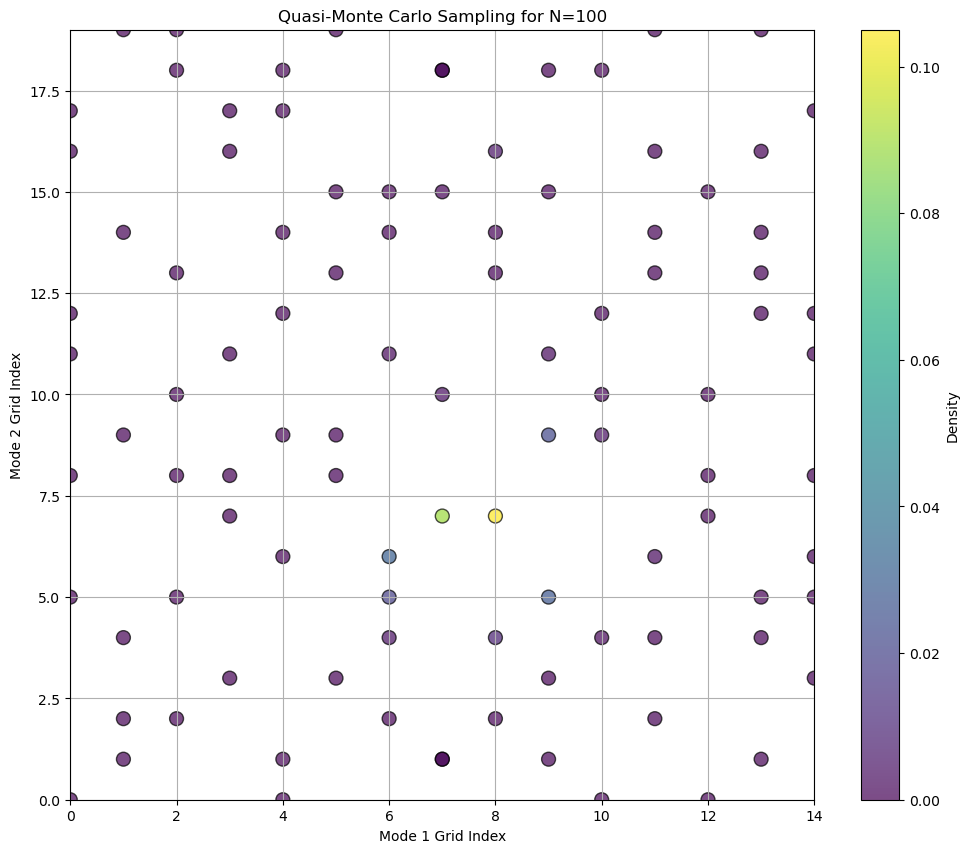

In [91]:
import numpy as np
from scipy.stats import qmc
import concurrent.futures

# Grid values for each dimension (non-uniform spacing)
grid_values = [full_1dden_data[i][0][:, 0] for i in range(number_nmodes)]

grid_sizes = [len(grid) for grid in grid_values]  # Number of grid points per dimension
n_samples = (10)**2                                # Should be a power of 2 for Sobol sequences

# Generate QMC points
sampler = qmc.Sobol(number_nmodes, scramble=True)
qmc_points = sampler.random(n=n_samples)

# Map QMC points to discrete grid indices
representative_indices = []
for u in qmc_points:
    indices = []
    for i, ui in enumerate(u):
        Ni = grid_sizes[i]
        ki = min(int(np.floor(ui * Ni)), Ni - 1)  # Map u_i to index k_i
        indices.append(ki)
    representative_indices.append(indices)

# Initialize sp_psi with the same length as representative_indices
sp_psi = [None] * len(representative_indices)

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    futures_to_idx = {
        executor.submit(
            mct.run_and_collect,
            sp_full_path,
            sp_flags,
            grid
        ): idx
        for idx, grid in enumerate(representative_indices)
    }
    
    for future in concurrent.futures.as_completed(futures_to_idx):
        idx = futures_to_idx[future]
        psi = future.result()
        if psi is not None:
            sp_psi[idx] = psi  # Make sure to store the psi_values in the correct order
            print(f"Sample {idx + 1}: Collected psi_values.")
        else:
            print(f"Sample {idx + 1}: Failed to collect psi_values.")

# Plot the QMC points on the grid
plot = True
if plot:
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        np.array(representative_indices)[:,0],
        np.array(representative_indices)[:,1],
        c=sp_psi,
        cmap='viridis',
        marker='o',
        edgecolor='k',
        s=100,
        alpha=0.7
    )
    plt.colorbar(scatter, label='Density')
    plt.xlabel('Mode 1 Grid Index')
    plt.ylabel('Mode 2 Grid Index')
    plt.title(f'Quasi-Monte Carlo Sampling for N={n_samples}')
    plt.grid(True)
    plt.xlim(0, grid_shape[0] -1)
    plt.ylim(0, grid_shape[1] -1)
    plt.show()


In [87]:
full_1dden_data[:][0][:,0]

TypeError: list indices must be integers or slices, not tuple